### Import libraries

In [1]:
import os
import sys

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# import own modules
sys.path.append("..")  # Adds higher directory to python modules path.
from scripts import features as ft
from scripts import preprocessing as pp
from scripts import evaluate_models as em

# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
plt.style.use(
    "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle"
)

---
## Preparations

### Load the CSV into a Dataframe

- load csv (or calculate again if not in data folder)
- update index=id
- drop useless columns
- find numerical & object columns

In [2]:
# path to csv file
path_df = os.path.join("..", "data", "df_deepgaze2e.csv")

# get features - or recalculate
recalculate_df = False
if os.path.isfile(path_df) and not recalculate_df:
    df = pd.read_csv(path_df)
else:
    df = ft.get_features()
    df.to_csv(path_df, index=False)

# set id as index
df = df.set_index("id", drop=True)

# drop first batch of useless variables
df = df.drop(columns=["img", "sp_idx"])
df = df.drop(
    columns=[col for col in df.columns if "_obj" in col]
)  # drop 'object' columns

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

 -> dataframe has 7598 instances and 34 columns
 -> there are 34 numerical columns
 -> there are 0 categoricals columns


### First, drop instances & features

- unusual long fixation durations are identified as outliers and dropped
  - drop if "dur > 5000 ms"
- drop `sal_first_above_0.75*max_rank` & `sal_first_above_0.9*max_rank` since this features consists of mainly (33% / 61%) outlier values
  - outliers are coded as "20" 


In [3]:
# processing
df = df[df["sp_fix_duration_ms_total"] <= 5000]
df = df.drop(columns=["sal_first_above_0.75*max_rank", "sal_first_above_0.9*max_rank"])

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

 -> dataframe has 7217 instances and 32 columns
 -> there are 32 numerical columns
 -> there are 0 categoricals columns


### Checking for highly correlated columns
think after running this lines, which column to additionally drop

Correlation between sp_fix_duration_ms_total and sal_weighted_duration_sum is 0.828
Correlation between sp_fix_duration_ms_mean and sal_weighted_duration_mean is 0.815
Correlation between obj_n_fix_face and obj_t_abs_on_face is 0.822
Correlation between obj_n_fix_face and obj_t_rel_on_face is 0.801
Correlation between obj_n_fix_inanimate and obj_t_abs_on_inanimate is 0.868
Correlation between obj_n_fix_inanimate and obj_t_rel_on_inanimate is 0.841
Correlation between obj_n_fix_background and obj_t_abs_on_background is 0.84
Correlation between obj_n_fix_background and obj_t_rel_on_background is 0.804


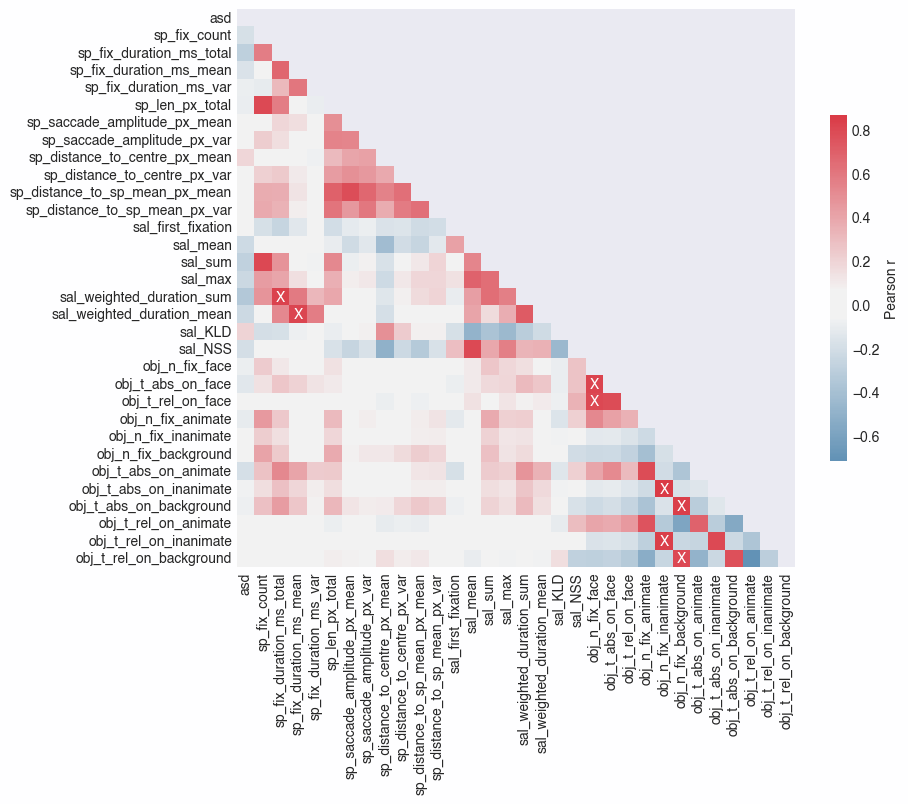

In [4]:
# check for correlations
pp.check_correlations(df[num_cols], thresh=0.8)

### further processing of correlating features
- `sp_fix_duration_ms_total` & `sp_fix_duration_ms_mean`
  - keep the `saliency weighted` version of both fixation duration measures
- `obj_n_fix_*`
  - keep the time measures of object recognition features

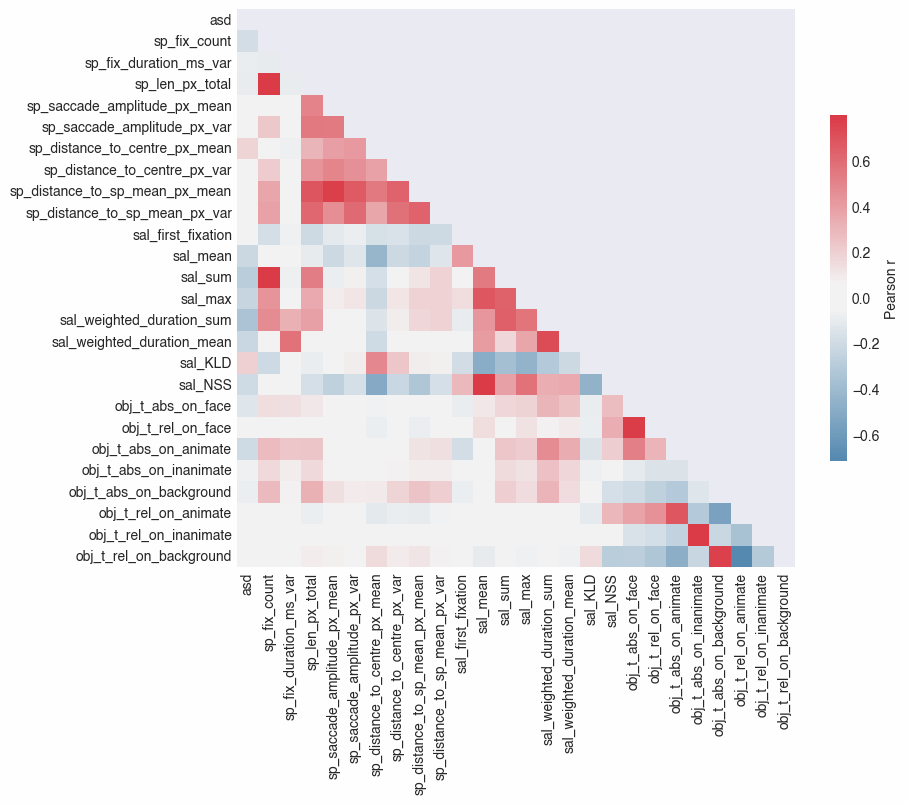

 -> dataframe has 7217 instances and 26 columns
 -> there are 26 numerical columns
 -> there are 0 categoricals columns


In [5]:
# processing
df = df.drop(
    columns=[
        "sp_fix_duration_ms_total",
        "sp_fix_duration_ms_mean",
        "obj_n_fix_face",
        "obj_n_fix_animate",
        "obj_n_fix_inanimate",
        "obj_n_fix_background",
    ]
)

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# check for correlations, again
pp.check_correlations(df[num_cols], thresh=0.8)

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

### Split into train & test sets

As soon as the dataset is in its final form, perform train-test-split with our own split function to have out 30-image-set always as our test set.

In [6]:
# prepare features and target
X = df
y = X.pop("asd")

# train-test-split
X_train, X_test, y_train, y_test = pp.split(X, y)

# print info
print(f"train-set has '{len(y_train)}' samples & '{X.shape[1]}' features")
print(f"test-set has '{len(y_test)}' samples - out of '{df.shape[0]}'")
print(f"  ~ {len(y_test) / df.shape[0] * 100:.2f}% of full dataset")

train-set has '6485' samples & '25' features
test-set has '732' samples - out of '7217'
  ~ 10.14% of full dataset


### Set variables

- define `metric`
- behavior for saving models as pickles
- defaults for model-objects

In [7]:
# metric
ftwo_scorer = make_scorer(fbeta_score, beta=2)

# model_folder
default_mdl_folder = 'RF_Grid_dg'

# defaults
RSEED = 42
cv = 10
n_jobs = -1
verbose = 1

---
## Model - Preparations

### Column Transformers for Data Preproccessing
these are only used for certain Models, which we expect to perform better with Preproccessed Data

In [8]:
# add other transformations at the end if needed
transformer = [
    ("scaler", MinMaxScaler(), num_cols),
    ("ohe", OneHotEncoder(drop="first"), cat_cols),
]

preprocessing = ColumnTransformer(transformer, remainder="passthrough")

###  Pipelines for each Model

In [9]:
# Random Forest: no scaling / no encoding
rf_pipeline = Pipeline([("classifier", RandomForestClassifier())])

---
## Modeling

### Random Forest

#### 1: Full Grid

In [10]:
# grid
param_grid_rf = {
    "classifier__n_estimators": [100, 200, 300, 400, 500],
    "classifier__max_depth": [5, 10, 20, 30, 50],
    "classifier__min_samples_split": [2, 5, 10, 20, 50, 100],
    "classifier__min_samples_leaf": [1, 2, 5, 10, 20],
    "classifier__max_features": ["sqrt", "log2"],
}

# Create GridSearchCV object & fit it
grid_search_rf_v1 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
)

# set file & folder name
model_name = "RF_grid_v1_full.pickle"

# fit or load
grid_search_rf_v1 = em.fit_or_load(
    grid_search_rf_v1, X_train, y_train, model_name, folder=default_mdl_folder
)

 -> model loaded from: '../models/RF_Grid_dg/RF_grid_v1_full.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.899     0.905     0.902      3252
           1      0.904     0.898     0.901      3233

    accuracy                          0.901      6485
   macro avg      0.901     0.901     0.901      6485
weighted avg      0.901     0.901     0.901      6485

f(0.5)-score: 0.902
f(2.0)-score: 0.899

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.701     0.744     0.722       371
           1      0.719     0.673     0.695       361

    accuracy                          0.709       732
   macro avg      0.710     0.709     0.708       732
weighted avg      0.710     0.709     0.709       732

f(0.5)-score: 0.709
f(2.0)-score: 0.682



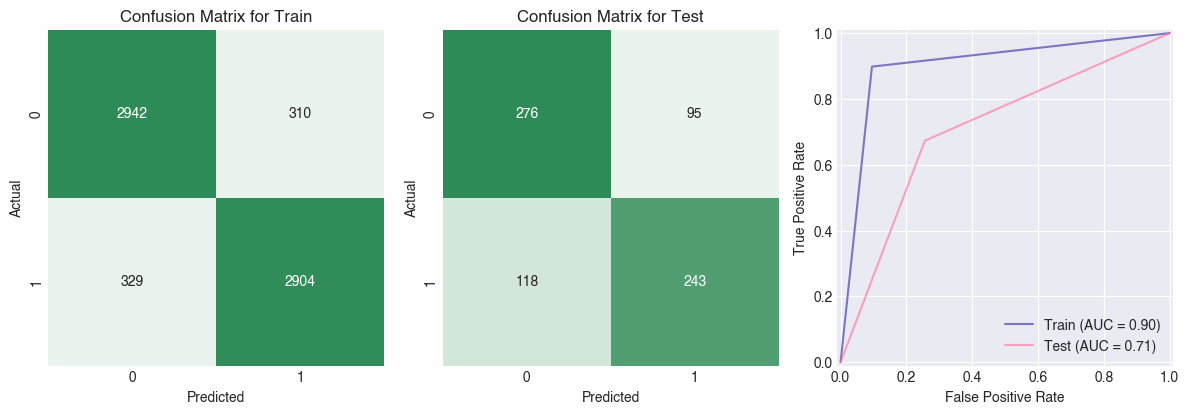

In [11]:
# predict & proba
pred_test = grid_search_rf_v1.predict(X_test)
proba_test = grid_search_rf_v1.predict_proba(X_test)

pred_train = grid_search_rf_v1.predict(X_train)
proba_train = grid_search_rf_v1.predict_proba(X_train)

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [12]:
# Get the best parameters and best estimator
em.model_info(grid_search_rf_v1)

# # feature importances
# em.feat_importance(grid_search_rf, X_train, y_train, X_test, y_test)

# # learning curves - for one model - f2 score
# em.learning(grid_search_rf.best_estimator_, X_train, y_train)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=30, max_features='log2',
                                        min_samples_leaf=2,
                                        min_samples_split=20,
                                        n_estimators=200))])

 ----- best parameter: -----
{'classifier__max_depth': 30,
 'classifier__max_features': 'log2',
 'classifier__min_samples_leaf': 2,
 'classifier__min_samples_split': 20,
 'classifier__n_estimators': 200}

 ----- RandomForestClassifier -----
   has on average 780 nodes
   has on average a maximum depth of 22



---

#### 2: prune "max_depth" & "min_sample_leafs"

In [13]:
# grid
param_grid_rf = {
    "classifier__max_depth": [5, 10, 20],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [5, 10, 20],
    "classifier__min_samples_split": [2, 5, 10, 20, 50, 100],
    "classifier__n_estimators": [200, 300, 400],
}

# Create GridSearchCV object & fit it
grid_search_rf_v2 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
)

# set file & folder name
model_name = "RF_grid_v2_pruning.pickle"

# fit or load
grid_search_rf_v2 = em.fit_or_load(
    grid_search_rf_v2, X_train, y_train, model_name, folder=default_mdl_folder
)

 -> model loaded from: '../models/RF_Grid_dg/RF_grid_v2_pruning.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.834     0.844     0.839      3252
           1      0.841     0.831     0.836      3233

    accuracy                          0.838      6485
   macro avg      0.838     0.838     0.838      6485
weighted avg      0.838     0.838     0.838      6485

f(0.5)-score: 0.839
f(2.0)-score: 0.833

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.695     0.744     0.719       371
           1      0.716     0.665     0.690       361

    accuracy                          0.705       732
   macro avg      0.706     0.704     0.704       732
weighted avg      0.706     0.705     0.704       732

f(0.5)-score: 0.705
f(2.0)-score: 0.675



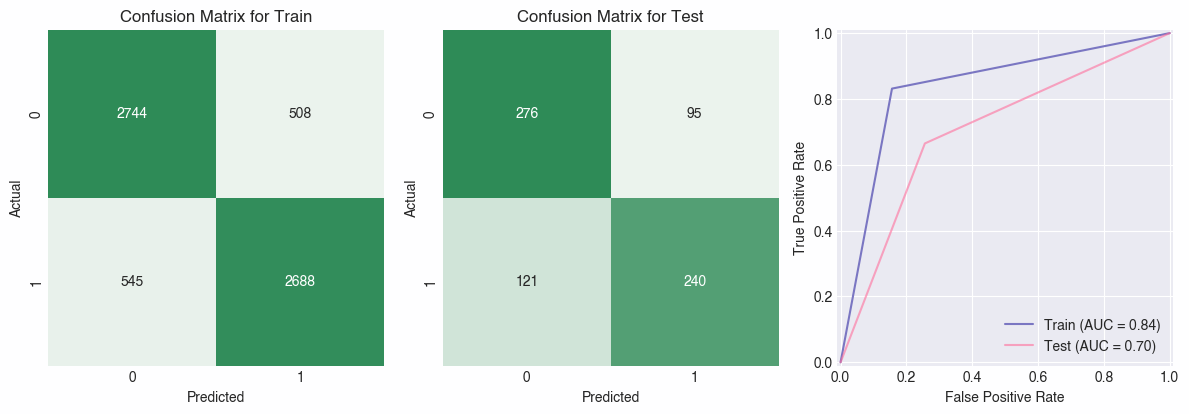

In [14]:
# predict & proba
pred_test = grid_search_rf_v2.predict(X_test)
proba_test = grid_search_rf_v2.predict_proba(X_test)

pred_train = grid_search_rf_v2.predict(X_train)
proba_train = grid_search_rf_v2.predict_proba(X_train)

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [15]:
# Get the best parameters and best estimator
em.model_info(grid_search_rf_v2)

# # feature importances
# em.feat_importance(grid_search_rf, X_train, y_train, X_test, y_test)

# # learning curves - for one model - f2 score
# em.learning(grid_search_rf.best_estimator_, X_train, y_train)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=20, min_samples_leaf=10,
                                        n_estimators=200))])

 ----- best parameter: -----
{'classifier__max_depth': 20,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 10,
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 200}

 ----- RandomForestClassifier -----
   has on average 597 nodes
   has on average a maximum depth of 18



---

#### 3: pruning "min_samples_split" & "max_depth"

In [16]:
# grid
param_grid_rf = {
    "classifier__max_depth": [5, 10, 15],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [5, 10, 20],
    "classifier__min_samples_split": [10, 20, 50],
    "classifier__n_estimators": [200, 300, 400],
}

# Create GridSearchCV object & fit it
grid_search_rf_v3 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
)

# set file & folder name
model_name = "RF_grid_v3_pruning.pickle"

# fit or load
grid_search_rf_v3 = em.fit_or_load(
    grid_search_rf_v3, X_train, y_train, model_name, folder=default_mdl_folder
)

 -> model loaded from: '../models/RF_Grid_dg/RF_grid_v3_pruning.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.797     0.797     0.797      3252
           1      0.796     0.796     0.796      3233

    accuracy                          0.796      6485
   macro avg      0.796     0.796     0.796      6485
weighted avg      0.796     0.796     0.796      6485

f(0.5)-score: 0.796
f(2.0)-score: 0.796

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.693     0.725     0.709       371
           1      0.703     0.670     0.687       361

    accuracy                          0.698       732
   macro avg      0.698     0.698     0.698       732
weighted avg      0.698     0.698     0.698       732

f(0.5)-score: 0.697
f(2.0)-score: 0.677



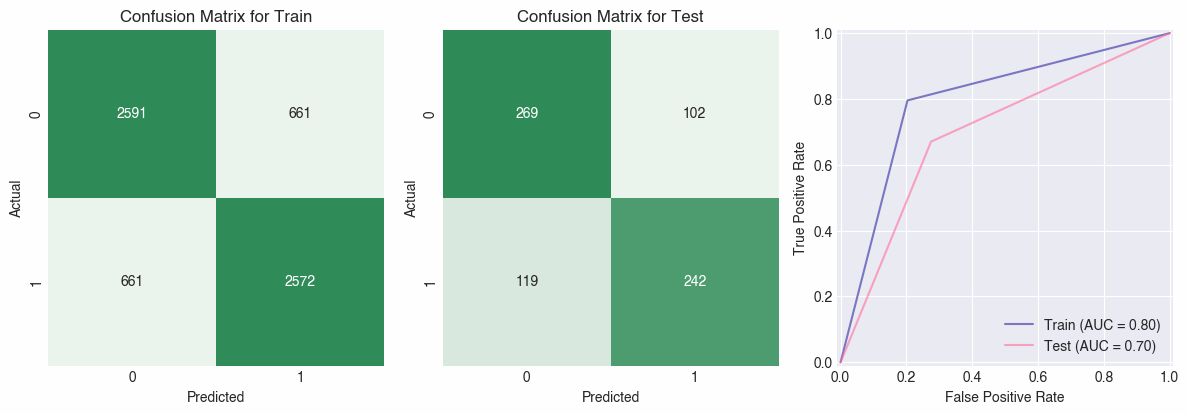

In [17]:
# predict & proba
pred_test = grid_search_rf_v3.predict(X_test)
proba_test = grid_search_rf_v3.predict_proba(X_test)

pred_train = grid_search_rf_v3.predict(X_train)
proba_train = grid_search_rf_v3.predict_proba(X_train)

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [18]:
# Get the best parameters and best estimator
em.model_info(grid_search_rf_v3)

# # feature importances
# em.feat_importance(grid_search_rf_v3, X_train, y_train, X_test, y_test)

# # learning curves - for one model - f2 score
# em.learning(grid_search_rf_v3.best_estimator_, X_train, y_train)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=15, min_samples_leaf=5,
                                        min_samples_split=50,
                                        n_estimators=200))])

 ----- best parameter: -----
{'classifier__max_depth': 15,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 5,
 'classifier__min_samples_split': 50,
 'classifier__n_estimators': 200}

 ----- RandomForestClassifier -----
   has on average 327 nodes
   has on average a maximum depth of 14



---

#### 4: more pruning: "max_depth" & "min_samples_leaf" & "min_samples_split"

In [19]:
# grid
param_grid_rf = {
    "classifier__max_depth": [8, 10, 12],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [8, 12, 16],
    "classifier__min_samples_split": [30, 40, 50],
    "classifier__n_estimators": [150, 200, 250],
}

# Create GridSeardchCV object & fit it
grid_search_rf_v4 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
)

# set file & folder name
model_name = "RF_grid_v4_pruning.pickle"

# fit or load
grid_search_rf_v4 = em.fit_or_load(
    grid_search_rf_v4, X_train, y_train, model_name, folder=default_mdl_folder
)

 -> model loaded from: '../models/RF_Grid_dg/RF_grid_v4_pruning.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.801     0.807     0.804      3252
           1      0.804     0.799     0.801      3233

    accuracy                          0.803      6485
   macro avg      0.803     0.803     0.803      6485
weighted avg      0.803     0.803     0.803      6485

f(0.5)-score: 0.803
f(2.0)-score: 0.800

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.691     0.747     0.718       371
           1      0.716     0.657     0.685       361

    accuracy                          0.702       732
   macro avg      0.703     0.702     0.701       732
weighted avg      0.703     0.702     0.702       732

f(0.5)-score: 0.703
f(2.0)-score: 0.668



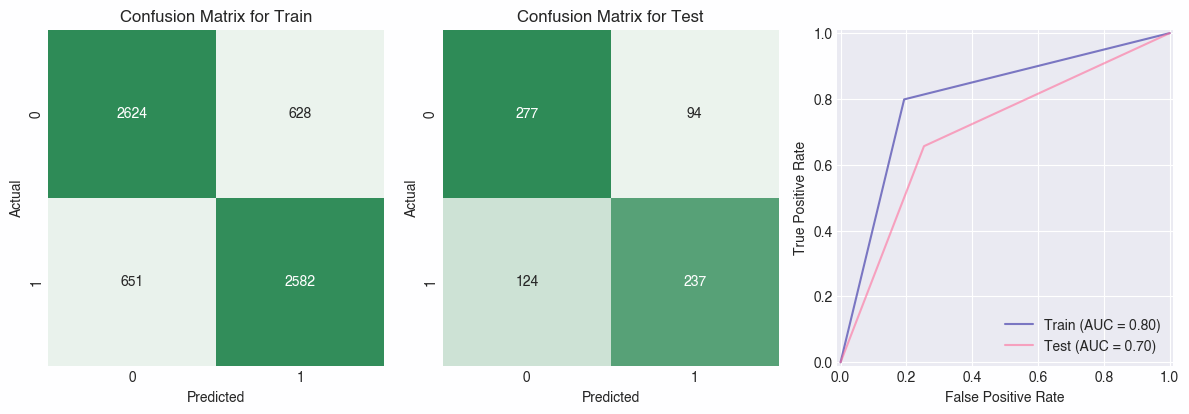

In [20]:
# predict & proba
pred_test = grid_search_rf_v4.predict(X_test)
proba_test = grid_search_rf_v4.predict_proba(X_test)

pred_train = grid_search_rf_v4.predict(X_train)
proba_train = grid_search_rf_v4.predict_proba(X_train)

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [21]:
# Get the best parameters and best estimator
em.model_info(grid_search_rf_v4)

# # feature importances
# em.feat_importance(grid_search_rf_v3, X_train, y_train, X_test, y_test)

# # learning curves - for one model - f2 score
# em.learning(grid_search_rf_v3.best_estimator_, X_train, y_train)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=12, min_samples_leaf=8,
                                        min_samples_split=30,
                                        n_estimators=150))])

 ----- best parameter: -----
{'classifier__max_depth': 12,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 8,
 'classifier__min_samples_split': 30,
 'classifier__n_estimators': 150}

 ----- RandomForestClassifier -----
   has on average 381 nodes
   has on average a maximum depth of 12



---

#### 5: finetuning I

In [22]:
# grid
param_grid_rf = {
    "classifier__max_depth": [10, 11],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [9, 10, 11],
    "classifier__min_samples_split": [33, 36],
    "classifier__n_estimators": [150, 200],
}

# Create GridSeardchCV object & fit it
grid_search_rf_v5 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
)

# set file & folder name
model_name = "RF_grid_v5_pruning.pickle"

# fit or load
grid_search_rf_v5 = em.fit_or_load(
    grid_search_rf_v5, X_train, y_train, model_name, folder=default_mdl_folder
)

 -> model loaded from: '../models/RF_Grid_dg/RF_grid_v5_pruning.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.782     0.789     0.785      3252
           1      0.786     0.778     0.782      3233

    accuracy                          0.784      6485
   macro avg      0.784     0.784     0.784      6485
weighted avg      0.784     0.784     0.784      6485

f(0.5)-score: 0.784
f(2.0)-score: 0.780

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.693     0.744     0.718       371
           1      0.716     0.662     0.688       361

    accuracy                          0.704       732
   macro avg      0.705     0.703     0.703       732
weighted avg      0.704     0.704     0.703       732

f(0.5)-score: 0.704
f(2.0)-score: 0.672



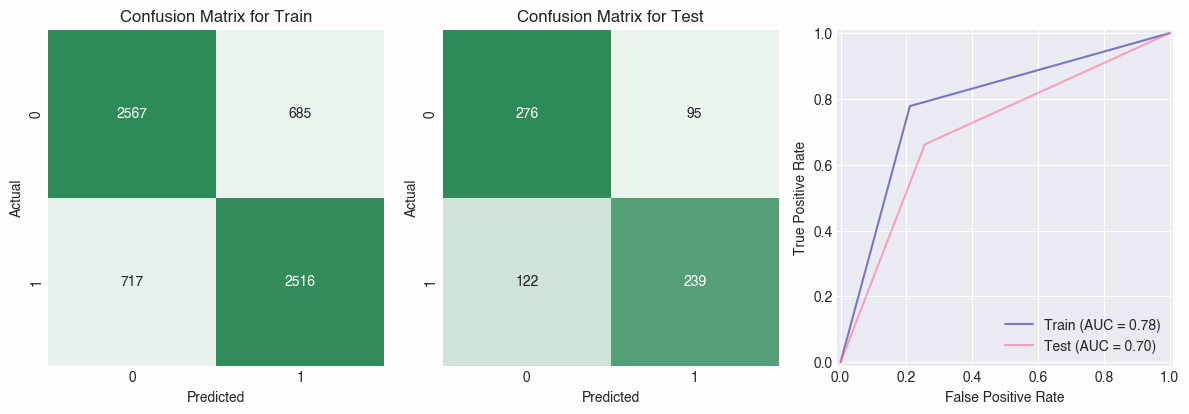

In [23]:
# predict & proba
pred_test = grid_search_rf_v5.predict(X_test)
proba_test = grid_search_rf_v5.predict_proba(X_test)

pred_train = grid_search_rf_v5.predict(X_train)
proba_train = grid_search_rf_v5.predict_proba(X_train)

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [24]:
# Get the best parameters and best estimator
em.model_info(grid_search_rf_v5)

# # feature importances
# em.feat_importance(grid_search_rf_v5, X_train, y_train, X_test, y_test)

# # learning curves - for one model - f2 score
# em.learning(grid_search_rf_v5.best_estimator_, X_train, y_train)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=11, min_samples_leaf=10,
                                        min_samples_split=36,
                                        n_estimators=150))])

 ----- best parameter: -----
{'classifier__max_depth': 11,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 10,
 'classifier__min_samples_split': 36,
 'classifier__n_estimators': 150}

 ----- RandomForestClassifier -----
   has on average 309 nodes
   has on average a maximum depth of 11



---

#### 6: finetuning II

In [25]:
# grid
param_grid_rf = {
    "classifier__max_depth": [9, 10],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [9, 10, 11],
    "classifier__min_samples_split": [33, 36, 39],
    "classifier__n_estimators": [100, 150, 200],
}

# Create GridSeardchCV object & fit it
grid_search_rf_v6 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
)

# set file & folder name
model_name = "RF_grid_v6_pruning.pickle"

# fit or load
grid_search_rf_v6 = em.fit_or_load(
    grid_search_rf_v6, X_train, y_train, model_name, folder=default_mdl_folder
)

 -> model loaded from: '../models/RF_Grid_dg/RF_grid_v6_pruning.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.772     0.784     0.778      3252
           1      0.779     0.767     0.773      3233

    accuracy                          0.775      6485
   macro avg      0.775     0.775     0.775      6485
weighted avg      0.775     0.775     0.775      6485

f(0.5)-score: 0.777
f(2.0)-score: 0.769

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.701     0.752     0.726       371
           1      0.725     0.670     0.696       361

    accuracy                          0.712       732
   macro avg      0.713     0.711     0.711       732
weighted avg      0.713     0.712     0.711       732

f(0.5)-score: 0.713
f(2.0)-score: 0.681



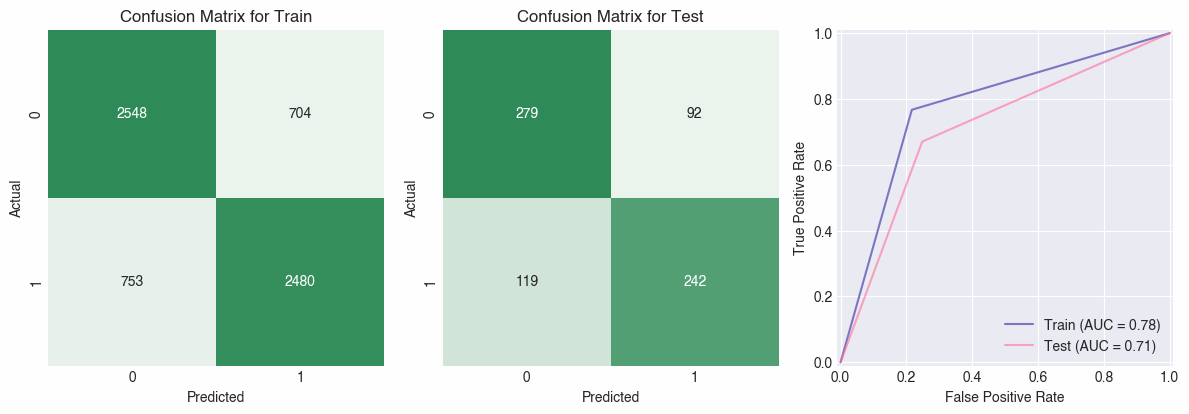

In [26]:
# predict & proba
pred_test = grid_search_rf_v6.predict(X_test)
proba_test = grid_search_rf_v6.predict_proba(X_test)

pred_train = grid_search_rf_v6.predict(X_train)
proba_train = grid_search_rf_v6.predict_proba(X_train)

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [27]:
# Get the best parameters and best estimator
em.model_info(grid_search_rf_v6)

# # feature importances
# em.feat_importance(grid_search_rf_v6, X_train, y_train, X_test, y_test)

# # learning curves - for one model - f2 score
# em.learning(grid_search_rf_v6.best_estimator_, X_train, y_train)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=9,
                                        min_samples_split=36))])

 ----- best parameter: -----
{'classifier__max_depth': 10,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 9,
 'classifier__min_samples_split': 36,
 'classifier__n_estimators': 100}

 ----- RandomForestClassifier -----
   has on average 275 nodes
   has on average a maximum depth of 10



---

#### 7: finetuning III

In [28]:
# grid
param_grid_rf = {
    "classifier__max_depth": [8, 9],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [9, 10, 11],
    "classifier__min_samples_split": [33, 36, 39],
    "classifier__n_estimators": [80, 100, 120],
}

# Create GridSeardchCV object & fit it
grid_search_rf_v7 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
)

# set file & folder name
model_name = "RF_grid_v7_pruning.pickle"

# fit or load
grid_search_rf_v7 = em.fit_or_load(
    grid_search_rf_v7, X_train, y_train, model_name, folder=default_mdl_folder
)

 -> model loaded from: '../models/RF_Grid_dg/RF_grid_v7_pruning.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.760     0.767     0.764      3252
           1      0.763     0.757     0.760      3233

    accuracy                          0.762      6485
   macro avg      0.762     0.762     0.762      6485
weighted avg      0.762     0.762     0.762      6485

f(0.5)-score: 0.762
f(2.0)-score: 0.758

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.707     0.755     0.730       371
           1      0.729     0.679     0.703       361

    accuracy                          0.717       732
   macro avg      0.718     0.717     0.717       732
weighted avg      0.718     0.717     0.717       732

f(0.5)-score: 0.718
f(2.0)-score: 0.688



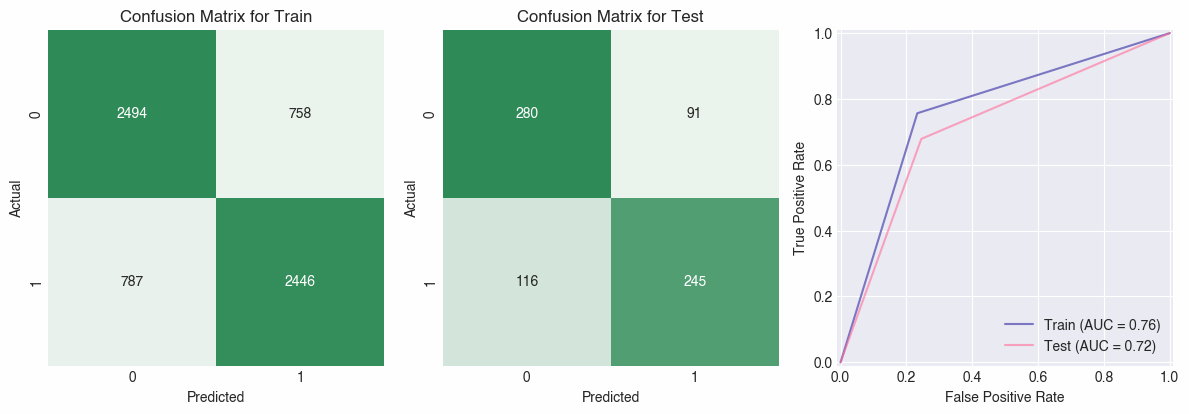

In [29]:
# predict & proba
pred_test = grid_search_rf_v7.predict(X_test)
proba_test = grid_search_rf_v7.predict_proba(X_test)

pred_train = grid_search_rf_v7.predict(X_train)
proba_train = grid_search_rf_v7.predict_proba(X_train)

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [30]:
# Get the best parameters and best estimator
em.model_info(grid_search_rf_v7)

# # feature importances
# em.feat_importance(grid_search_rf_v7, X_train, y_train, X_test, y_test)

# # learning curves - for one model - f2 score
# em.learning(grid_search_rf_v7.best_estimator_, X_train, y_train)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=9, min_samples_leaf=11,
                                        min_samples_split=36,
                                        n_estimators=80))])

 ----- best parameter: -----
{'classifier__max_depth': 9,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 11,
 'classifier__min_samples_split': 36,
 'classifier__n_estimators': 80}

 ----- RandomForestClassifier -----
   has on average 228 nodes
   has on average a maximum depth of 9



---

#### 8: finetuning IV

In [31]:
# grid
param_grid_rf = {
    "classifier__max_depth": [8],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [30],
    "classifier__min_samples_split": [60],
    "classifier__n_estimators": [80, 85, 90],
}

# Create GridSeardchCV object & fit it
grid_search_rf_v8 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
)

# set file & folder name
model_name = "RF_grid_v8_pruning.pickle"

# fit or load
grid_search_rf_v8 = em.fit_or_load(
    grid_search_rf_v8, X_train, y_train, model_name, folder=default_mdl_folder
)

 -> model loaded from: '../models/RF_Grid_dg/RF_grid_v8_pruning.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.729     0.731     0.730      3252
           1      0.729     0.727     0.728      3233

    accuracy                          0.729      6485
   macro avg      0.729     0.729     0.729      6485
weighted avg      0.729     0.729     0.729      6485

f(0.5)-score: 0.728
f(2.0)-score: 0.727

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.698     0.755     0.725       371
           1      0.725     0.665     0.694       361

    accuracy                          0.710       732
   macro avg      0.712     0.710     0.710       732
weighted avg      0.711     0.710     0.710       732

f(0.5)-score: 0.712
f(2.0)-score: 0.676



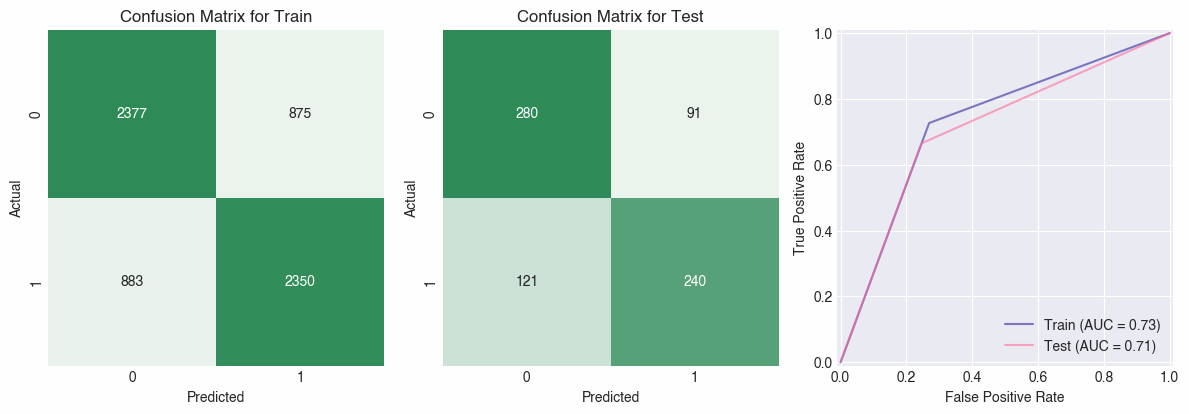

In [32]:
# predict & proba
pred_test = grid_search_rf_v8.predict(X_test)
proba_test = grid_search_rf_v8.predict_proba(X_test)

pred_train = grid_search_rf_v8.predict(X_train)
proba_train = grid_search_rf_v8.predict_proba(X_train)

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [33]:
# Get the best parameters and best estimator
em.model_info(grid_search_rf_v8)

# # feature importances
# em.feat_importance(grid_search_rf_v8, X_train, y_train, X_test, y_test)

# # learning curves - for one model - f2 score
# em.learning(grid_search_rf_v8.best_estimator_, X_train, y_train)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=8, min_samples_leaf=30,
                                        min_samples_split=60,
                                        n_estimators=90))])

 ----- best parameter: -----
{'classifier__max_depth': 8,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 30,
 'classifier__min_samples_split': 60,
 'classifier__n_estimators': 90}

 ----- RandomForestClassifier -----
   has on average 142 nodes
   has on average a maximum depth of 8



---

#### 9: finetuning V

In [34]:
# grid
param_grid_rf = {
    "classifier__max_depth": [7],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [30],
    "classifier__min_samples_split": [60],
    "classifier__n_estimators": [75, 80, 85],
}

# Create GridSeardchCV object & fit it
grid_search_rf_v9 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
)

# set file & folder name
model_name = "RF_grid_v9_pruning.pickle"

# fit or load
grid_search_rf_v9 = em.fit_or_load(
    grid_search_rf_v9, X_train, y_train, model_name, folder=default_mdl_folder
)

 -> model loaded from: '../models/RF_Grid_dg/RF_grid_v9_pruning.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.719     0.739     0.729      3252
           1      0.730     0.710     0.720      3233

    accuracy                          0.725      6485
   macro avg      0.725     0.725     0.725      6485
weighted avg      0.725     0.725     0.725      6485

f(0.5)-score: 0.726
f(2.0)-score: 0.714

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.697     0.749     0.722       371
           1      0.721     0.665     0.692       361

    accuracy                          0.708       732
   macro avg      0.709     0.707     0.707       732
weighted avg      0.709     0.708     0.707       732

f(0.5)-score: 0.709
f(2.0)-score: 0.675



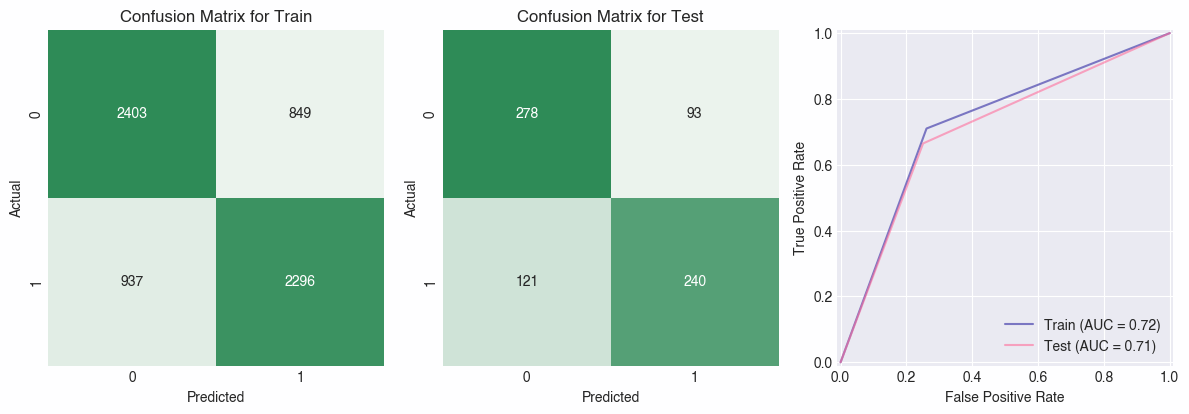

In [35]:
# predict & proba
pred_test = grid_search_rf_v9.predict(X_test)
proba_test = grid_search_rf_v9.predict_proba(X_test)

pred_train = grid_search_rf_v9.predict(X_train)
proba_train = grid_search_rf_v9.predict_proba(X_train)

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [36]:
# Get the best parameters and best estimator
em.model_info(grid_search_rf_v9)

# # feature importances
# em.feat_importance(grid_search_rf_v9, X_train, y_train, X_test, y_test)

# # learning curves - for one model - f2 score
# em.learning(grid_search_rf_v9.best_estimator_, X_train, y_train)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=7, min_samples_leaf=30,
                                        min_samples_split=60,
                                        n_estimators=85))])

 ----- best parameter: -----
{'classifier__max_depth': 7,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 30,
 'classifier__min_samples_split': 60,
 'classifier__n_estimators': 85}

 ----- RandomForestClassifier -----
   has on average 112 nodes
   has on average a maximum depth of 7



---

### error

In [37]:
# em.error_images(y_test, pred_test, proba_test=proba_test)

#### compare models

In [38]:
import os
import math
import pickle
import pprint
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import imageio.v3 as iio
from tqdm import tqdm
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay,
    fbeta_score,
    make_scorer,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
)
from sklearn.inspection import permutation_importance
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
from scripts import utils as ut

30it [00:02, 11.47it/s]


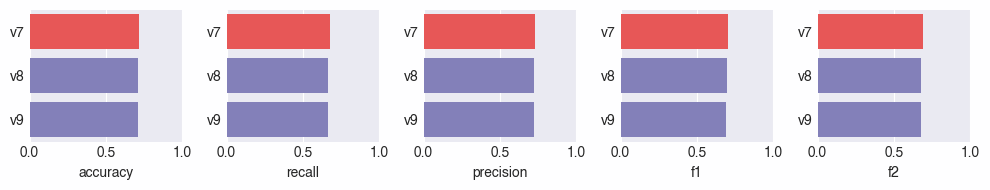

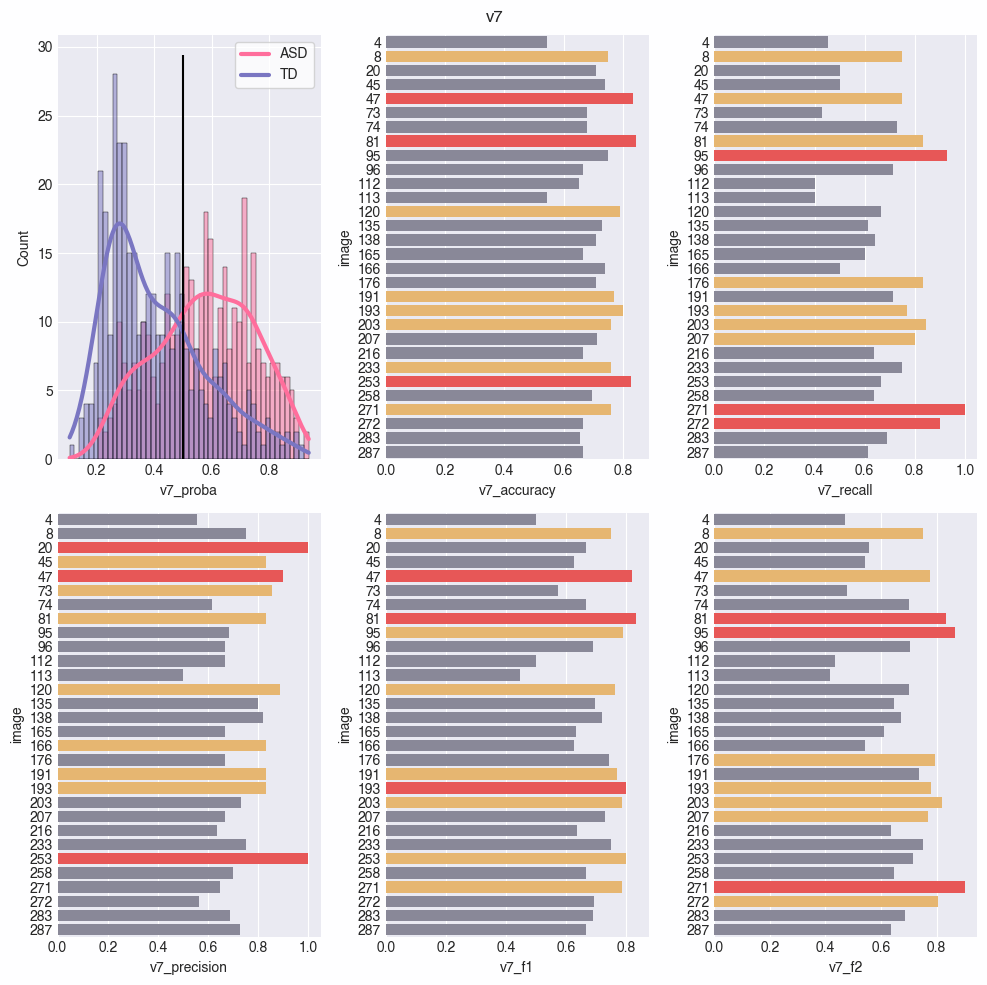

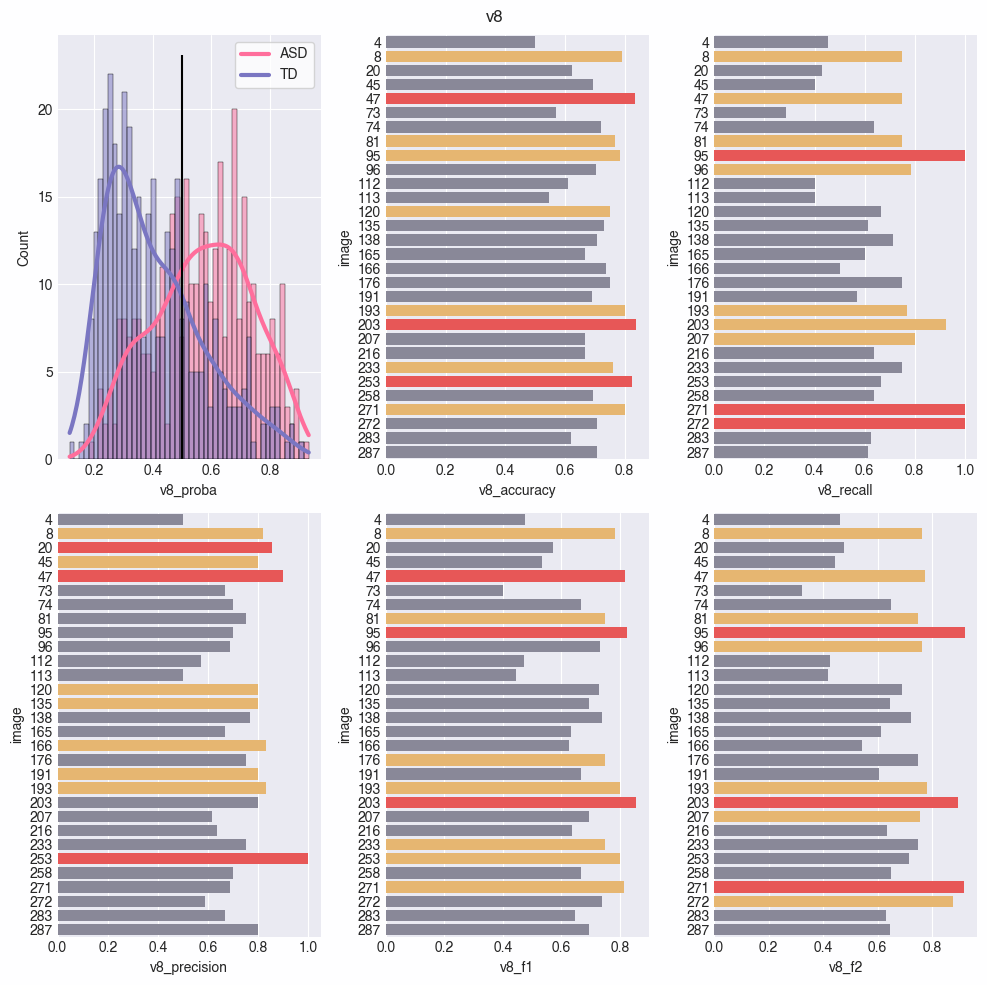

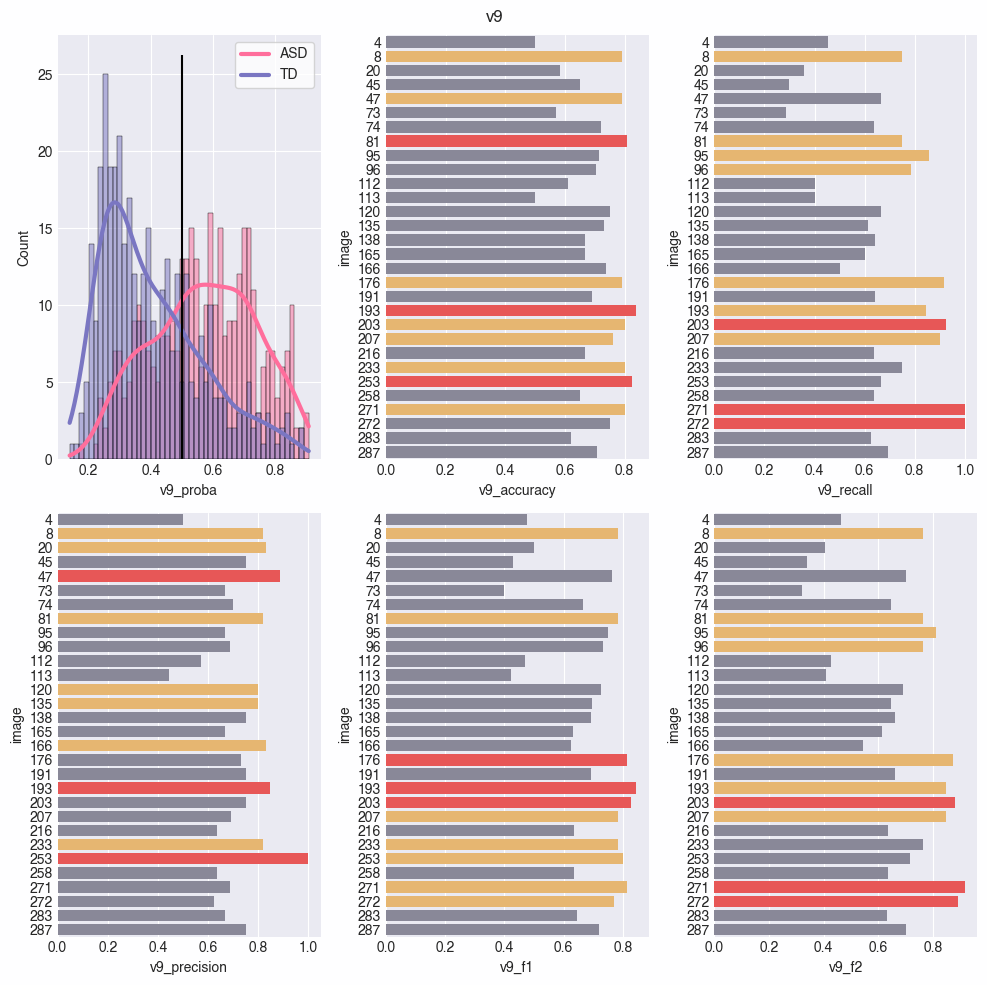

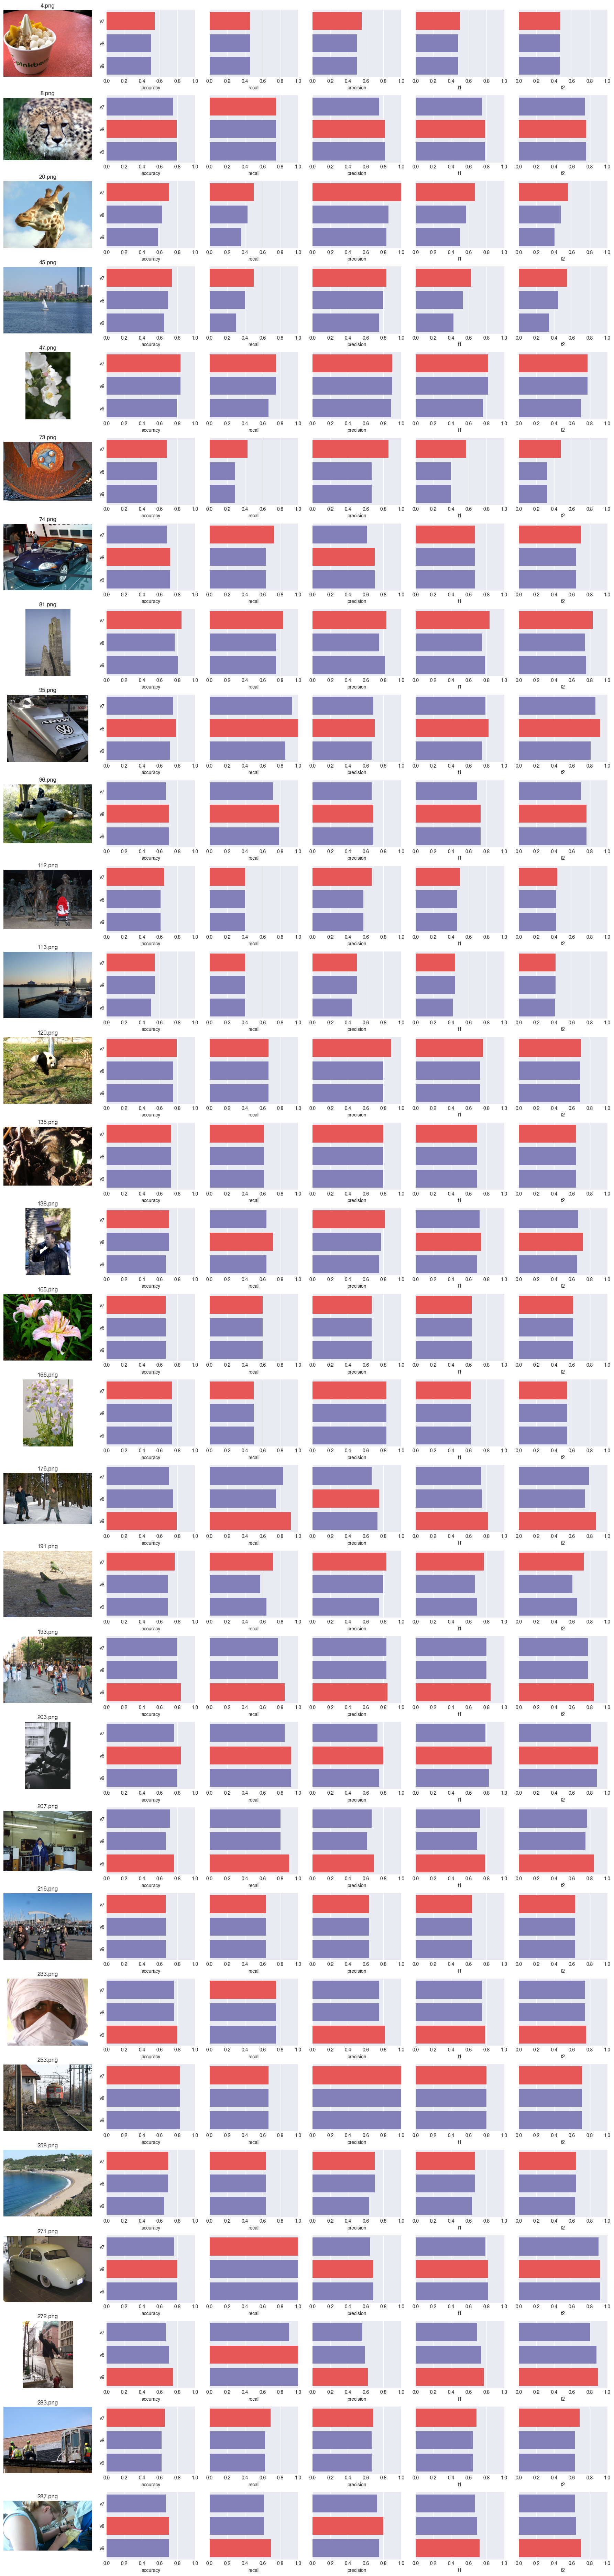

In [39]:
names = ["v7", "v8", "v9"]
inp = {
    "v7": [grid_search_rf_v7.predict(X_test), grid_search_rf_v7.predict_proba(X_test)],
    "v8": [grid_search_rf_v8.predict(X_test), grid_search_rf_v8.predict_proba(X_test)],
    "v9": [grid_search_rf_v9.predict(X_test), grid_search_rf_v9.predict_proba(X_test)],
}
em.error_compare_models(inp, y_test)


----

### try stacking last three models

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import pickle

# ----------------------------------------------------------------
def load_models(
    model_folder="testing",
    model_names=["xgb_model.pkl", "rf_model.pkl", "svc_model.pkl"],
):
    models = dict()
    for model_name in model_names:
        model_path = os.path.join("..", "models", model_folder, model_name)
        with open(model_path, "rb") as f:
            model_key = model_name.split(".")[
                0
            ]  # Extracting model name without extension
            models[model_key] = pickle.load(f)

    return models

mdls = load_models(
    model_folder="RF_grid_dg",
    model_names=[
        "RF_grid_v7_pruning.pickle",
        "RF_grid_v8_pruning.pickle",
        "RF_grid_v9_pruning.pickle",
    ],
)


In [ ]:
# ----------------------------------------------------------------
def get_stacking(models, X_train, y_train):
    # Define the base models
    level0 = [
        ("rf_v7", models["RF_grid_v7_pruning"]),
        ("rf_v8", models["RF_grid_v8_pruning"]),
        ("rf_v9", models["RF_grid_v9_pruning"]),
    ]
    # Define meta learner model
    level1 = LogisticRegression()

    # Define the stacking ensemble
    stacking_model = StackingClassifier(estimators=level0, final_estimator=level1, cv='prefit')

    # Fit the stacking model
    stacking_model.fit(X_train, y_train)
    return stacking_model

stck_mdl = get_stacking(mdls, X_train, y_train)


In [ ]:
# ----------------------------------------------------------------
def stacking_pred_proba(stacking_model, X_train, X_test):
    # predict & proba
    pred_test = stacking_model.predict(X_test)
    proba_test = stacking_model.predict_proba(X_test)

    pred_train = stacking_model.predict(X_train)
    proba_train = stacking_model.predict_proba(X_train)

    return pred_train, proba_train, pred_test, proba_test

pred_train, proba_train, pred_test, proba_test = stacking_pred_proba(stck_mdl, X_train, X_test)


In [ ]:
# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)